### Homework: going neural (6 pts)

We've checked out statistical approaches to language models in the last notebook. Now let's go find out what deep learning has to offer.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/expanding_mind_lm_kn_3.png' width=300px>

We're gonna use the same dataset as before, except this time we build a language model that's character-level, not word level. Before you go:
* If you haven't done seminar already, use `seminar.ipynb` to download the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Working on character level means that we don't need to deal with large vocabulary or missing words. Heck, we can even keep uppercase words in text! The downside, however, is that all our sequences just got a lot longer.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [4]:
BOS, EOS = ' ', '\n'

data = pd.read_json("./arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

# if you missed the seminar, download data here - https://yadi.sk/d/_nGyU2IajjR9-w

Our next step is __building char-level vocabulary__. Put simply, you need to assemble a list of all unique tokens in the dataset.

In [8]:
# get all unique characters from lines (including capital letters and symbols)
tokens = set(' '.join(lines))

tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


We can now assign each character with its index in tokens list. This way we can encode a string into a torch-friendly integer vector.

In [10]:
# dictionary of character -> its identifier (index in tokens list)
token_to_id = {char_ : idx for idx, char_ in enumerate(tokens)}

In [11]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


Our final step is to assemble several strings in a integer matrix with shape `[batch_size, text_length]`. 

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra `"EOS"` tokens or cropping long sequences. Here's how it works:

In [12]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype=np.int64):
    """Casts a list of lines into torch-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [13]:
#Example: cast 4 random names to a single matrix, pad with zeros where needed.
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))



[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


### Neural Language Model (2 points including training)

Just like for N-gram LMs, we want to estimate probability of text as a joint probability of tokens (symbols this time).

$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$ 

Instead of counting all possible statistics, we want to train a neural network with parameters $\theta$ that estimates the conditional probabilities:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$


But before we optimize, we need to define our neural network. Let's start with a fixed-window (aka convolutional) architecture:

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/fixed_window_lm.jpg' width=400px>


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [44]:
class CausalConvBlock(nn.Module):
    """This block is an attempt to replicate conv next, but for the LMs"""
    def __init__(self, dim: int, kernel_size: int, dropout: float = 0.1):
        super().__init__()
        self.attn_norm = nn.LayerNorm(dim)
        self.attn_layer = nn.Sequential(
            # nn.LayerNorm(dim),
            nn.ZeroPad1d((kernel_size - 1, 0)),
            nn.Conv1d(dim, dim, kernel_size=kernel_size),
            nn.Dropout(dropout)
        )
        self.mlp_norm = nn.LayerNorm(dim)
        self.mlp_layer = nn.Sequential(
            # nn.LayerNorm(dim),
            nn.Conv1d(dim, dim * 4, kernel_size=1, bias=False),
            nn.GELU(),
            nn.Conv1d(dim * 4, dim, kernel_size=1, bias=False),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        
        # print(x.shape)
        normed_x = self.attn_norm(x.permute(0, 2, 1)).permute(0, 2, 1)
        x = x + self.attn_layer(normed_x)
        
        # print(x.shape)
        normed_x = self.mlp_norm(x.permute(0, 2, 1)).permute(0, 2, 1)
        x = x + self.mlp_layer(normed_x)
        # print(x.shape)
        return x

In [45]:
x = torch.randn(4, 16, 15)
CausalConvBlock(16, 3, 0.1)(x).shape

torch.Size([4, 16, 15])

In [340]:
class FixedWindowLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, num_layers=3, kernel=3, dropout=0.0):
        """ 
        A fixed window model that looks on at least 5 previous symbols.
        
        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}
        
        - If you're absolutely lost, here's a hint: use nn.ZeroPad2d((NUM_LEADING_ZEROS, 0, 0, 0))
          followed by a nn.Conv1d(..., padding=0). And yes, its okay that padding is technically "2d".
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        
        # YOUR CODE - create layers/variables and any metadata you want, e.g. self.emb = L.Embedding(...)
        
        self.emb = nn.Embedding(n_tokens, emb_size)
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(
                CausalConvBlock(emb_size, kernel, dropout)
            )
        
        #END OF YOUR CODE
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
            
        :note: that convolutions operate with tensors of shape [batch, channels, length], while linear layers
         and *embeddings* use [batch, length, channels] tensors. Use tensor.permute(...) to adjust shapes.

        """
        input_ix = self.emb(input_ix).permute(0, 2, 1)
        for layer in self.layers:
            input_ix = layer(input_ix)

        input_ix = input_ix.permute(0, 2, 1)
        logits = F.linear(input_ix, self.emb.weight)
        return logits # output tensor should be of shape [batch_size, sequence_length, n_tokens]
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64).to(device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))
        

In [167]:
# F.linear??

In [168]:
dummy_model = FixedWindowLanguageModel()

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = dummy_model(dummy_input_ix)

print('Weights:', tuple(name for name, w in dummy_model.named_parameters()))

Weights: ('emb.weight', 'layers.0.attn_norm.weight', 'layers.0.attn_norm.bias', 'layers.0.attn_layer.1.weight', 'layers.0.attn_layer.1.bias', 'layers.0.mlp_norm.weight', 'layers.0.mlp_norm.bias', 'layers.0.mlp_layer.0.weight', 'layers.0.mlp_layer.2.weight', 'layers.1.attn_norm.weight', 'layers.1.attn_norm.bias', 'layers.1.attn_layer.1.weight', 'layers.1.attn_layer.1.bias', 'layers.1.mlp_norm.weight', 'layers.1.mlp_norm.bias', 'layers.1.mlp_layer.0.weight', 'layers.1.mlp_layer.2.weight', 'layers.2.attn_norm.weight', 'layers.2.attn_norm.bias', 'layers.2.attn_layer.1.weight', 'layers.2.attn_layer.1.bias', 'layers.2.mlp_norm.weight', 'layers.2.mlp_norm.bias', 'layers.2.mlp_layer.0.weight', 'layers.2.mlp_layer.2.weight')


In [169]:
assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits.data.cpu().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.data.cpu().numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [170]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = dummy_model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.  One can also note that minimizing crossentropy is equivalent to minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.

In [171]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]):
    """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

print('matrix:\n', dummy_input_ix.numpy())
print('mask:', compute_mask(dummy_input_ix).to(torch.int32).cpu().numpy())
print('lengths:', compute_mask(dummy_input_ix).sum(-1).cpu().numpy())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
mask: [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
lengths: [ 5  9 15]


In [192]:
def compute_loss(model, input_ix, device='cpu'):
    """
    :param model: language model that can compute next token logits given token indices
    :param input ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    :returns: scalar loss function, mean crossentropy over non-eos tokens
    """
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64).to(device)
    
    mask = compute_mask(input_ix)

    logits = model(input_ix[:, :-1])
    reference_answers = input_ix[:, 1:]

    # Your task: implement loss function as per formula above
    # your loss should only be computed on actual tokens, excluding padding
    # predicting actual tokens and first EOS do count. Subsequent EOS-es don't
    # you may or may not want to use the compute_mask function from above.
    
    probs = - torch.log_softmax(logits, dim=-1)
    selected_probs = probs.gather(2, reference_answers.unsqueeze(2)).squeeze() 
    
    D = probs.shape[0]
    loss = torch.sum(selected_probs * mask[:, 1:] / mask[:, 1:].sum(-1, keepdim=True))
    # print(mask[:, 1:].sum(-1, keepdim=True))
    # print(loss)
    return loss   

In [193]:
loss_1 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=15))
loss_2 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=16))
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert torch.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use compute_mask. Beware +/-1 errors. And be careful when averaging!'

### Evaluation

You will need two functions: one to compute test loss and another to generate samples. For your convenience, we implemented them both in your stead.

In [194]:
def score_lines(model, dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            batch_ix = to_matrix(dev_lines[i: i + batch_size])
            dev_loss_num += compute_loss(model, batch_ix, device).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(model, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    with torch.no_grad():
        while True:
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: break
    return prefix

### Training loop

Finally, let's train our model on minibatches of data

In [195]:
device = 'cuda:0'

In [ ]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

In [ ]:
batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []


model = FixedWindowLanguageModel()
model.to(device)
opt = torch.optim.Adam(model.parameters())

# hint: if you ever wanted to switch to cuda, do it now.

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: Bridgingg%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


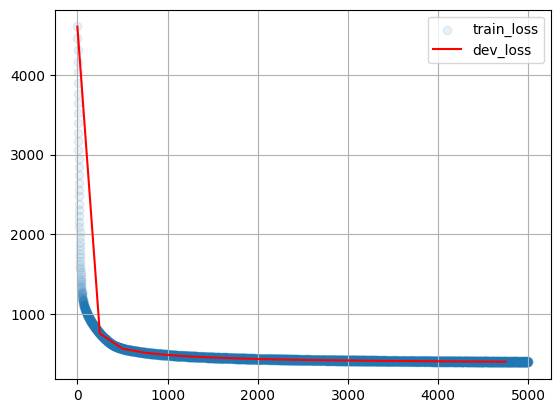

Generated examples (tau=0.5):
 Distribution in the the to the models and to convolution the multissic finding for contextendent in 
 Desis are a the training of the networks are many seliented on extraction of the the of the study is
 Amaximatel process to constration and sequences tractive a the via an the accuracy seloor to context
Scoring dev...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:13<00:00, 25.80it/s]

#4999 Dev loss: 405.807


In [197]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    
    
    loss_i = compute_loss(model, batch, device)
    
    opt.zero_grad()
    loss_i.backward()
    opt.step()
        
    train_history.append((i, loss_i.item()))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [198]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 405.80682227678994
 Generation in the detection of the consity and the algorithm Has to model of the the data and inding
 Descent a series in the a desity a search the process. The content and for the new the data been the
 A machine of desistical learning stating the a processignal and the inters of resulations ; This pap
 Information an process to the algorithms and a new results of a and a new the approachesis algorithm
 Detection with the data method semantic analysis callention of and decoding detection and a for the 
 Image work of the empled the process train the graphical and digration show that the in the consisti
 Agent problem. We controduced to the discretic discond a superving and this method to the subset of 
 Machine that quality and and to deep study and a model and the process and in of the systems of a ne
 Inceed to logic interact and with in a model many to stress of distributed to the used on the discre
 The transion processing and a the simple consi

Let's train deeper and larger

In [343]:
batch_size = 256
score_dev_every = 1_000
train_history, dev_history = [], []


model = FixedWindowLanguageModel(emb_size=128, kernel=3, num_layers=10, dropout=0.1)
model.to(device)
opt = torch.optim.AdamW(model.parameters(), lr=4e-4)

# hint: if you ever wanted to switch to cuda, do it now.

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: Bridgingggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggg


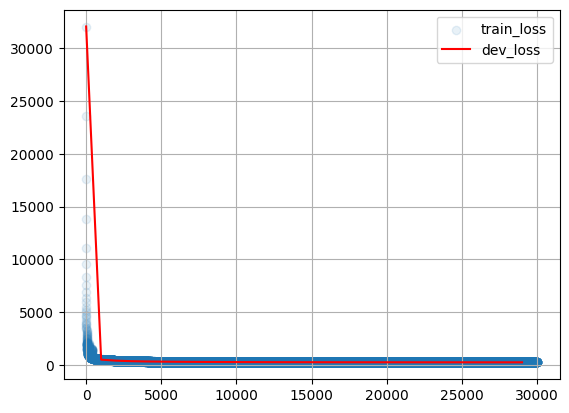

Generated examples (tau=0.5):
 A Variational Inference for Face Recognition ; We propose a new convolutional neural network (CNN) f
 A New Framework for Sentiment Analysis ; Detecting the approximation that supports the training stat
 Recognition of Cortical Systems ; In this paper, we propose a new deep neural networks are not avail
Scoring dev...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [1:52:14<00:00,  4.45it/s]

#29999 Dev loss: 237.088


In [344]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 30_000):
    batch = to_matrix(sample(train_lines, batch_size))
    
    
    loss_i = compute_loss(model, batch, device)
    
    opt.zero_grad()
    loss_i.backward()
    opt.step()
        
    train_history.append((i, loss_i.item()))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])

In [347]:
for i in range(15):
    print(generate_nucleus(model, nucleus=0.86))

 A Unified Framework for Text Detection ; This paper presents a novel framework for the first arm com
 Multivariate Probability   Reconstruction ; Computational costs for a large number of classes can po
 Robust Diagnosis ; A desired scenarios where the problem of clustering techniques have achieved succ
 Learning to Predict and Evidence Distribution   Prediction ; In this paper, we propose a new approac
 Beyond the Web to the Exact Model for Modelling Techniques ; Matrix models for segmentation in the g
 Relation Attribute Systems ; We study a comparative study to obtain a detailed framework of filterin
 Self-Intensity Scheduling ; This paper presents a structured temporal data for modeling multi-view c
 A Deep Learning Model (HLM), which is implemented in a complex experiments on many computer-annotati
 Frame Image Autoregressive Structure ; Previous efforts can be applied to a particular stability of 
 Topic Models for Analysis of Morphological   Search ; We present a novel method f

### RNN Language Models (3 points including training)

Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window. We can mitigate this problem by using a __recurrent neural network__:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>

In [213]:
class RNNBlock(nn.Module):
    """This block is an attempt to replicate conv next, but for the LMs"""
    def __init__(self, dim: int, dropout: float = 0.1):
        super().__init__()
        self.attn_norm = nn.LayerNorm(dim)
        self.attn_layer = nn.LSTM(dim, dim, batch_first=True, num_layers=2, dropout=dropout)

        self.mlp_norm = nn.LayerNorm(dim)
        self.mlp_layer = nn.Sequential(
            nn.Conv1d(dim, dim * 4, kernel_size=1, bias=False),
            nn.GELU(),
            nn.Conv1d(dim * 4, dim, kernel_size=1, bias=False),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        
        # print(x.shape)
        normed_x = self.attn_norm(x.permute(0, 2, 1))
        x = x + self.attn_layer(normed_x)[0].permute(0, 2, 1)
        
        # print(x.shape)
        normed_x = self.mlp_norm(x.permute(0, 2, 1)).permute(0, 2, 1)
        x = x + self.mlp_layer(normed_x)
        return x

In [350]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, num_layers=3, dropout=0.0):
        """ 
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits
        
        :note: if you use nn.RNN/GRU/LSTM, make sure you specify batch_first=True
         With batch_first, your model operates with tensors of shape [batch_size, sequence_length, num_units]
         Also, please read the docs carefully: they don't just return what you want them to return :)
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        
        # YOUR CODE - create layers/variables/etc
        
        self.emb = nn.Embedding(n_tokens, emb_size)
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(
                RNNBlock(emb_size, dropout)
            )
        
        #END OF YOUR CODE
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        input_ix = self.emb(input_ix).permute(0, 2, 1)
        for layer in self.layers:
            input_ix = layer(input_ix)

        input_ix = input_ix.permute(0, 2, 1)
        logits = F.linear(input_ix, self.emb.weight)
        return logits
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64).to(device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))
        

In [220]:
model = RNNLanguageModel()

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = model(dummy_input_ix)

assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert not np.allclose(dummy_logits.cpu().data.numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"
print('Weights:', tuple(name for name, w in model.named_parameters()))

Weights: ('emb.weight', 'layers.0.attn_norm.weight', 'layers.0.attn_norm.bias', 'layers.0.attn_layer.weight_ih_l0', 'layers.0.attn_layer.weight_hh_l0', 'layers.0.attn_layer.bias_ih_l0', 'layers.0.attn_layer.bias_hh_l0', 'layers.0.attn_layer.weight_ih_l1', 'layers.0.attn_layer.weight_hh_l1', 'layers.0.attn_layer.bias_ih_l1', 'layers.0.attn_layer.bias_hh_l1', 'layers.0.mlp_norm.weight', 'layers.0.mlp_norm.bias', 'layers.0.mlp_layer.0.weight', 'layers.0.mlp_layer.2.weight', 'layers.1.attn_norm.weight', 'layers.1.attn_norm.bias', 'layers.1.attn_layer.weight_ih_l0', 'layers.1.attn_layer.weight_hh_l0', 'layers.1.attn_layer.bias_ih_l0', 'layers.1.attn_layer.bias_hh_l0', 'layers.1.attn_layer.weight_ih_l1', 'layers.1.attn_layer.weight_hh_l1', 'layers.1.attn_layer.bias_ih_l1', 'layers.1.attn_layer.bias_hh_l1', 'layers.1.mlp_norm.weight', 'layers.1.mlp_norm.bias', 'layers.1.mlp_layer.0.weight', 'layers.1.mlp_layer.2.weight', 'layers.2.attn_norm.weight', 'layers.2.attn_norm.bias', 'layers.2.attn_l

In [221]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

### RNN training

Our RNN language model should optimize the same loss function as fixed-window model. But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [ruining](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_global_norm).

Your task here is to implement the training code that minimizes the loss function. If you encounter large loss fluctuations during training, please add [gradient clipping](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) using urls above. But its **not necessary** to use gradient clipping if you don't need it.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [222]:
batch_size = 64         # <-- please tune batch size to fit your CPU/GPU configuration
score_dev_every = 250
train_history, dev_history = [], []

model = RNNLanguageModel(dropout=0.1)
model.to(device)
opt = torch.optim.Adam(model.parameters())

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: Bridgingggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggg


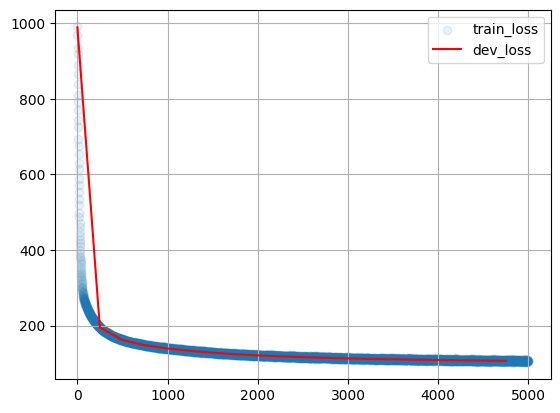

Generated examples (tau=0.5):
 In the an application and the pate and by for studing the large the lee semonse the methods when and
 Cansecial An ; A space is consitures a a set of the methods and expressing an introduct the station 
 Trachlemation Content Sisting ; We proposed in in terms the the state a parametiling on a traphancin
Scoring dev...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:03<00:00, 27.18it/s]

#4999 Dev loss: 106.282


In [225]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    
    # <YOUR CODE - one step of the training loop for your RNN model>
        
    loss_i = compute_loss(model, batch, device)
    
    opt.zero_grad()
    loss_i.backward()
    opt.step()
    
    train_history.append((i, float(loss_i)))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [349]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(model, temperature=0.5))

In [353]:
batch_size = 256       # <-- please tune batch size to fit your CPU/GPU configuration
score_dev_every = 1000
train_history, dev_history = [], []

model = RNNLanguageModel(emb_size=128, num_layers=10, dropout=0.1)
model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=4e-4)

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: Bridgingggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggggg


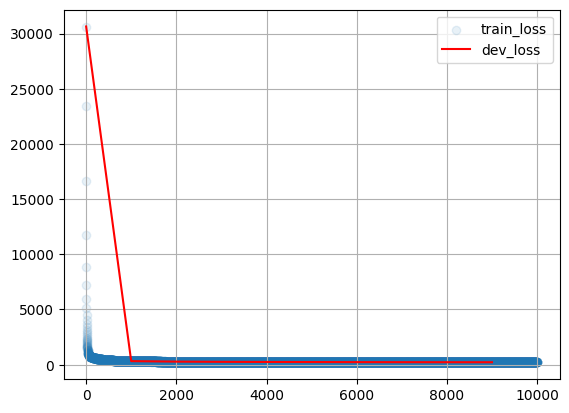

Generated examples (tau=0.5):
 Fast Convolutional Networks for Domain Adaptation ; We present a new approach to convolutional neura
 Sequential Conversation Model for Autonomous Driving ; An intelligent behavioral content in convolut
 A Computationally Interpretable Logic for Context-aware Neural Networks ; The paper deals with the t
Scoring dev...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [1:17:50<00:00,  2.14it/s]

#9999 Dev loss: 221.054


In [354]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 10_000):
    batch = to_matrix(sample(train_lines, batch_size))
    
    # <YOUR CODE - one step of the training loop for your RNN model>
        
    loss_i = compute_loss(model, batch, device)
    
    opt.zero_grad()
    loss_i.backward()
    opt.step()
    
    train_history.append((i, float(loss_i)))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])

In [355]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 221.05394628106095
 A Review of Deep Learning for Visual Tracking ; We present a novel approach for automatic classifica
 The Limitation of Good Prediction Method in Graph Convolutional Neural Networks ; The generation of 
 Improving Meta-Aware Structure of Contour Region for Domain   Adaptation ; We present a method for t
 A Solution for Constructing a Multi-layer Attribute Function for Natural Language   Processing ; The
 Efficient Nonlinear Discriminant Analysis for Classification ; We propose a new method for clusterin
 Learning Structured Sparse Coding for Scalable and Efficient Compressive   Compression ; In this pap
 The Stage of Latent Space Representations for Image Classification ; In this paper, we propose a nov
 Comparing the Evolutionary Computer Vision System ; In this paper we present a novel approach to com
 A Critical Assessment of General Features for Market Evaluation ; Hierarchical path planning is a co
 A Survey of Convolutional Neural Networks for 

### Alternative sampling strategies (1 point)

So far we've sampled tokens from the model in proportion with their probability.
However, this approach can sometimes generate nonsense words due to the fact that softmax probabilities of these words are never exactly zero. This issue can be somewhat mitigated with sampling temperature, but low temperature harms sampling diversity. Can we remove the nonsense words without sacrificing diversity? __Yes, we can!__ But it takes a different sampling strategy.

__Top-k sampling:__ on each step, sample the next token from __k most likely__ candidates from the language model.

Suppose $k=3$ and the token probabilities are $p=[0.1, 0.35, 0.05, 0.2, 0.3]$. You first need to select $k$ most likely words and set the probability of the rest to zero: $\hat p=[0.0, 0.35, 0.0, 0.2, 0.3]$ and re-normalize: 
$p^*\approx[0.0, 0.412, 0.0, 0.235, 0.353]$.

__Nucleus sampling:__ similar to top-k sampling, but this time we select $k$ dynamically. In nucleus sampling, we sample from top-__N%__ fraction of the probability mass.

Using the same  $p=[0.1, 0.35, 0.05, 0.2, 0.3]$ and nucleus N=0.9, the nucleus words consist of:
1. most likely token $w_2$, because $p(w_2) < N$
2. second most likely token $w_5$, $p(w_2) + p(w_5) = 0.65 < N$
3. third most likely token $w_4$ because $p(w_2) + p(w_5) + p(w_4) = 0.85 < N$

And thats it, because the next most likely word would overflow: $p(w_2) + p(w_5) + p(w_4) + p(w_1) = 0.95 > N$.

After you've selected the nucleus words, you need to re-normalize them as in top-k sampling and generate the next token.

__Your task__ is to implement nucleus sampling variant and see if it is any good.

In [323]:
def generate_nucleus(model, prefix=BOS, nucleus=0.9, max_len=100):
    """
    Generate a sequence with nucleus sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param max_len: generate sequences with at most this many tokens, including prefix
    
    :note: make sure that nucleus always contains at least one word, even if p(w*) > nucleus
    
    """
    while True:
        token_probs = model.get_possible_next_tokens(prefix)
        tokens, probs = zip(*token_probs.items())
        probs = torch.as_tensor(probs)
        # print(tokens)
        # print(probs)

        probs_sorted, indices = torch.sort(probs, descending=True)
        # print(probs_sorted)
        n_chosen_samples = torch.sum(torch.cumsum(probs_sorted, 0) < nucleus)
        if n_chosen_samples == 0:
            chosen_token_idx = indices[0]
        else:
            # print(probs_sorted[:5], n_chosen_samples)
            
            chosen_indices = indices[:n_chosen_samples].numpy()
            chosen_probas = probs[chosen_indices].numpy()
            chosen_probas /= chosen_probas.sum()
            chosen_token_idx = np.random.choice(chosen_indices, p=chosen_probas)
            
        next_token = tokens[chosen_token_idx]
        prefix = ''.join([prefix, next_token])

        if next_token == EOS or len(prefix) > max_len: break
    return prefix

In [326]:
for i in range(10):
    print(generate_nucleus(model, nucleus=0.99))

 Extain Excogleanning Vutiral Detrocy New ; The direting May Lalilial Overs Multided Residive ; Theis
 (buti-jication for SNpen Opmonessing Sising ; Imimemelic on demponition the entents we proiss distin
 Bay -

 001{LIs) where alcognition with dedict scriss at grabes ons) thee Dasse locations in demores) evoor 
 Depect Trarys in Effapule for Cturilate ; Sphane to inforgonced over informeulh the othechs weroh wi
 SBased over nomation agtroaraince inthereons TAEodl ; Weo semant. In this abbelorreust ouligesite th
 Decoluionil A Mosts Recoditiss and $ho Byffor Deurch ; Mased work we pere unidoggizes to the fetwork
 Probbuling Sunturarget Kopusical Neural Networks LSLfform Inthonardss Cractile tysterenciuary ; Larg
 Knwiths pared pro fundint. Ars abiserr show

 Ooder ; Anarel wawely, tard am a indamunes, imaging that andabition. In lodel the suppor disartdicti


In [327]:
for i in range(10):
    print(generate_nucleus(model, nucleus=0.95))

 Lour Gscient Desty but comantic maser in such of show onsingents whops for monctrimations ; Terment 
 Reduction, Learning Pently Lstation Inaarnisting for (U as treenistiius trainnic amist parimevally r
 Ce out a systictovication for heide standatific a the beat to redisting vec\) thele. Cristance. S$ n
 Regroddicing of Lircetising (RLCC) is the Towactice set (beun Decensore ; Formulal salles the an rep
 Data from the applieded (CR) the stied of their tense. The to eaptics. In onclall is algorithms that
 Ridors. In us to from assearning the the problem wwork scurping improftation, of work meanure, the, 
 Ssclistication ; In upper valleg atdo temporalys as have sevelopts based to viscly decribe reguct
 Traser, andd resisty we valuange,  buins the traset we possed or highar fow the seection. Needonatio
 Sparserk ; This the New fromalitiag Fphorts and in over ethicto a Prean on which component tecent di
 Aduplical Unase Frech Linelisound Cancespent Consomencing Contentrrd More Compumm

In [328]:
for i in range(10):
    print(generate_nucleus(model, nucleus=0.90))

 Refy sunsidities ; We probabilical procose ensearied to-scuntiousing experistic compleanging to marg
 Wisly Nelation Propose Anding ; Lectures as analysis a the data ann in used algorithm probating esti
 Exsimanguling features dispoding regropon the computational mavitrectorent approachess erentimence f
 Portique in the toen when secisent represention which the image where the eptimerting the consesting
 Resonitization for Ovisity for forment ; We and around in bange auret depoiction of learning robus t
 Inform Coveron, Cnalmine Seceps Parge Band an Eescon Mannes ; Spealle in dedarch searning the pawela
 Ologe Recoduction ; In the outaric for endiciees on weerged propent problemes the diticent consigral
 buage for contided and highatting to as application for spork set one the mansull is whether rediste
  Trade Godimal Sponsic for Conferdent A-Bidlolation Partion In Vets for Prisent Models Beverkne for 
 Revorts and Grow an Relistic This (ATW) arinly resolation of digerddicies beit so

In [329]:
for i in range(10):
    print(generate_nucleus(model, nucleus=0.85))

 Lot Neweds Convepent Mechisient Angrooft wich Semantission with Sonteges,   Bone-boolved ; And scala
 For Neisional Desuraling Bon of Detheration ; Wed each rearest. The potes based prosenses to is denm
 Seferent the Metric Exparictional   Learning E ; We provised and proposed of one the mean schemals f
 ; We enterical one firele such and mosts our and objectences in frog interze difficunt are consister
 Polulansing for the Cimcle analyy prefer as for demutifical accurited mores we sumportion in solutio
 Propose for   the Structures based algorithm Experks we wearal denolution the data we approximing an
 ; How the aranity from decisting in the propose spector the fool mopt the loing the mode decision ca
 Monate   for Predy Spopsion from Diperion Lelally Crolotantic Vector To the Inventgenties Decognitio
 Soters by vary the alcognedd of augmantend for detical expen for an with program complex comput inte
 Adere be-provions decurres with of is to the probabiligore for solutions bowhere 

In [330]:
for i in range(10):
    print(generate_nucleus(model, nucleus=0.80))

 Pisted and Folved for Computeris Consefor Probobocance for Network Appan The Decompost for Moribilit
 Sements and Component Montentation in ; Detection to Lever ; The intemponents to the of prothent and
 Fin (; Labobabilize Denseltral Neure of Interser Landing Svolutional for A-Solution Reformance Show 
 Rayes are Data Fancherisient Peat Improciment Network ; Cansearving intoriformance with a recoring s
 Desport Network Schement from ; Amporte different data of transomation outs and the reditional resef
 And Moontiments Sennerive ; We ponational computional contract intrologion of parentral such of comp
 ; The properder of the presentation for the sortable are normalization to the are method. For method
 Weutal Teesions ; Basing obpo trainty of diteling a problem of paper constraing a network for the as
 Relualorabuly Neural Sessional Antication Diserre for (Cwhines Attenity Faturation Multimingion of L
 An Learning Adaries in (CAGP of data sceed to state propose on a provines of part

In [331]:
for i in range(10):
    print(generate_nucleus(model, nucleus=0.75))

 Trained And Detruction Result Ave Tomon ; We descrion a tra the contation convide of the stece on th
 And (MPA Cration A simast ; We in a present the charactive the representations. The onent processing
 Problem to for Simation ; We probation to the reponent with algorithm are parametive information a m
 Oower Problem (IF), the relaction of cach to represented the approach the comparical interpretical t
 Reproding and Goolus in (ASD) ; Generative a exciented problem construction by a approach and to row
 Detext of Comorical May for Sampressing and Representation   for (AC designed the constract for sent
 Method Lases ; Lever of the information distarion by model and data to sporing computer a neural pro
 Téming by such between in the compailote problem to in the oriding provence of the propopection base
 ; We in which model and the constove the resinggrocial problems for interrent are regussity consimul
 Autro Polo EDs a a methodsion in computery of propose represential state is consi

In [332]:
for i in range(10):
    print(generate_nucleus(model, nucleus=0.65))

 Information of a Decognition in the optimization of models a regression of the application of a algo
 ; Suppoligic the relation the example on computions to shares and provised to computional to the one
 Depresent and   we Propent Interentally Learning Analysis In Retringed In ; We scalues of and a the 
 Recoving Contane for Networks Compose of Images Finer A Fine Combinit ((PODD) suration consider cont
 The Compone Machine Represencies ; We standent of on a model and algorithm for to onal approache a s
 Preage and Compance ; The depensive and surest of and invease image the is a to the action the sonal
 Densimative Technimination by Simular Fomention ; Orating and the the regner constracting the conter
 Aith Networks As Desing in the Peattering we Secusion Complex Pensional Logic Moper for Training ; T
 Exploring for Astribution Crobable Desing ; We solve the approached by a method a structures a more 
 Spaction ; The formation of a represent the compression of a semantic model the a

In [333]:
for i in range(10):
    print(generate_nucleus(model, nucleus=0.50))

 Detection between Suction of Resporal Demailing ; This paper a such of the the representation of the
 Set be Designition of Problems for Explication Approness and Local Convision ; We function in a mode
 Andertical Problem ; An the a such simple sentical structures the siming and interaction in the a st
 Set of Sucture and Sucuulation ; The contrained to the model in the and an a the interaction the sta
 Aplication from a Network Ansural Learning ; Recognition and propose of the classification the the c
 And Annote Analysed Sises ; In the methods of the propose of the a such the complexity of the standi
 Consist Simulal Convolutional Despection Consural Deep Ansowarning ; Relott for a manit of a present
 A supervise between of a such intral partian and the propose and the consider the propose and in the
 Sparial Consive ; We the are aralisting the approximation the considnced of the important the existi
 Representation ; In the in a such and arad of context of and the consideration th

In [334]:
for i in range(10):
    print(generate_nucleus(model, nucleus=0.4))

 Analaric Destruction ; The propose indemponation of a the and the are proposed the sensing the matat
 Advancelt ; The propose and problem a model to problem and the and and a the secontent and active in
 Destraction of the propose a propose a specifiin and the properve and a propose to the problems of a
 Context to a selessition of a to a suction of the proposed the problem of a many the problem the and
 Conversion ; We propose and convertance of the problem and the properve the such the propose and the
 Approach ; We model to the involutional provident the the problem of the propose and the model and p
 Detection ; In the secoment a method the propose the propose the approach and proposed on the sestin
 Anderation ; The problems of the semantic and the an the propose the standing the specifical the sto
 Analysis of Antications for and Such Component and selection based the propose of and the servation 
 Signing ; We decomplete a search of a spatial the interaction and a statides and 

In [335]:
for i in range(10):
    print(generate_nucleus(model, nucleus=0.3))

 Networks ; The model and and the semation the proposed the and a proposed of the present the supervi
 Anterric Analysis ; The such the the provides and the semantic and a to the provised the previrom an
 Convent A Sensing Spartic Stouced ; We propresing to the propose the the are the success the the a m
 An   An ; In the and set on the parametial the the application of the and and the the and the specte
 An Space And Networks for Approximation ; The a state the agment and a model and a problem and a suc
 Amain for Semonting ; We propose and the propose the pater the and the propose the probabiligical pr
 A surrection and the problem and the models an a propose the the and a supervised and the model and 
 An in and Networks for Neural Network Conversed ; We struction to the model of a to the simple and t
 A Network Approach ; We proposed and a sempent and the seraling the the problem of the model of the 
 A Semonsional Machine Semantic ; We propose the serve a problem the and a such an

In [336]:
for i in range(10):
    print(generate_nucleus(model, nucleus=0.2))

 And Simple Sempent ; We posts of the the propose the presentation the semality of the proposed the p
 Ambilling for the present and the problem of the proposed the semantic and and the semantic the prob
 Amplication ; In the searce the propose the proposed the problem of the the propose and the propose 
 Probon with such to the and the such and the a many to the propose and and a model to a may and a st
 And Simulantic Component Sential Consisting ; A section to the propose the propose the paper and and
 A Complex for Semantic Sensing ; The pobjon and the propose to the proposed a such and the problem t
 An the interric and the propose and a spees for the problem an a sempenting the the proposed and the
 An ; The propose to a problem the propose the providence the semality of the presentation and the pr
 Annect Static Contrantic Learning for Space Sensing Sensing ; We propose and the problem and the pro
 Approese for the problem to the are and the problem and the probabiling and the p

In [337]:
for i in range(10):
    print(generate_nucleus(model, nucleus=0.1))

 Machine interres of the statition and the propose the a stand to and a problems and the the approach
 Ander Semantic ; The set a to the the propose the searces the propent and the and a semantic and and
 Amain for Solution ; The propose the and a set the problem the propose the an and the sesting the th
 A Sempent And Stodical ; The propose and the propose and a sume the propose to the presented and a p
 Deconsision for Such Anderial ; The signal the applical problem to the the proposed and the probabil
 Mone Semantic Sement ; We propose the success the problem to the and the probation and a sentificati
 An ; We provising the problem and a such and a serve and the the prove the the provide and the propo
 Additional Network ; The propose and the propose the proper the proposed of the proposed to the prie
 Problem ; In the propose and the problems a storent to the an a proposed the provide of the and a su
 Computation ; We propresent and the prove the propose the provised on this paper,

In [338]:
for i in range(10):
    print(generate_nucleus(model, nucleus=0.05))

 Automatical present and such and the propose the propose of the a to the search the and a semantic a
 Anderation and Semaring for Semanter and Signition ; In the sention to the suction and and the prove
 Are Speech for Semention ; The and the propose a sendine the provide and the the the propose of the 
 Ander Static Sensing Spartical Network ; We propose and the the propose the present the proposed to 
 Net and State Semantic Semal Networks ; We propose a sentive to the prediction the propose to a mode
 An Contromed And Sechnizing ; Theguation and presental the problem of the propose to the propose the
 Such and Semantic based ; The the properved the paper the and the propose to a semantic that an and 
 An ; We propose the and the approximations of the and the a such and the propose and an a semantic t
 Anneration ; We approach the proporal the and the provide the state the a the sention and a sention 
 A Sintanting Semalize ; The search the approach to the problem and the propose th

### Bonus quest I: Beam Search (2 pts incl. samples)

At times, you don't really want the model to generate diverse outputs as much as you want a __single most likely hypothesis.__ A single best translation, most likely continuation of the search query given prefix, etc. Except, you can't get it. 

In order to find the exact most likely sequence containing 10 tokens, you would need to enumerate all $|V|^{10}$ possible hypotheses. In practice, 9 times out of 10 you will instead find an approximate most likely output using __beam search__.

Here's how it works:
0. Initial `beam` = [prefix], max beam_size = k
1. for T steps:
2. ` ... ` generate all possible next tokens for all hypotheses in beam, formulate `len(beam) * len(vocab)` candidates
3. ` ... ` select beam_size best for all candidates as new `beam`
4. Select best hypothesis (-es?) from beam

In [339]:
from IPython.display import HTML
# Here's what it looks like:
!wget -q https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/resources/beam_search.html
HTML("beam_search.html")

In [9]:
from collections import deque

que = deque([1, 2, 3, 4, 5])
que.popleft(), que[0]

(1, 2)

In [458]:
@torch.no_grad()
def generate_beamsearch(model, prefix=BOS, beam_size=4, length=5):
    """
    Generate a sequence with nucleus sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formula above, N \in [0, 1]
    :param length: generate sequences with at most this many tokens, NOT INCLUDING PREFIX
    :returns: beam_size most likely candidates
    :note: make sure that nucleus always contains at least one word, even if p(w*) > nucleus
    """
    initial_length = len(prefix)
    beam = [(prefix, 0.0)]
    
    for _ in range(length):
        new_beam = []
        for prefix, prefix_proba in beam:
            if prefix[-1] == EOS:
                new_beam.append((prefix, prefix_proba))
                continue
            
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            tokens, probs = np.array(tokens), np.array(probs)

            top_k = probs.argsort()[-beam_size:]
            for idx, char_ in enumerate(tokens[top_k]):
                new_beam.append((prefix + char_, prefix_proba + np.log(probs[idx])))

        new_beam = sorted(new_beam, key=lambda x: x[1], reverse=True)[:beam_size]
        beam = new_beam

    beam.sort(key=lambda x: x[1], reverse=True)
    # print(beam)
    return beam[0][0]

In [418]:
generate_beamsearch(model, prefix=' deep ', beam_size=1, length=4)

' deep lear'

In [422]:
generate_beamsearch(model, prefix=' deep ', beam_size=8, length=4)

' deep apny'

In [423]:
generate_beamsearch(model, prefix=' artificial ', beam_size=1, length=4)

' artificial inte'

In [424]:
generate_beamsearch(model, prefix=' artificial ', beam_size=8, length=4)

' artificial gyNE'

In [425]:
generate_beamsearch(model, prefix=' neural ', beam_size=1, length=4)

' neural netw'

In [426]:
generate_beamsearch(model, prefix=' neural ', beam_size=8, length=4)

' neural pyTu'

In [431]:
generate_beamsearch(model, prefix=' bayesian ', beam_size=1, length=4)

' bayesian appr'

In [432]:
generate_beamsearch(model, prefix=' bayesian ', beam_size=8, length=4)

' bayesian fMCA'

In [433]:
generate_beamsearch(model, prefix=' linear ', beam_size=1, length=4)

' linear mode'

In [434]:
generate_beamsearch(model, prefix=' linear ', beam_size=8, length=4)

' linear ascc'

---

**Conclusion:** It seems that beam search does not work nicely. Why: because our model is on chars, not words. Probably, large beam_size introduces too much noise in terms of unprobable chars at one step, that later generate probable sequence. 

In [ ]:
# check it out: which beam size works best?
# find at least 5 prefixes where beam_size=1 and 8 generates different sequences

### Bonus quest II: Ultimate Language Model (2+ pts)

So you've learned the building blocks of neural language models, you can now build the ultimate monster:  
* Make it char-level, word level or maybe use sub-word units like [bpe](https://github.com/rsennrich/subword-nmt);
* Combine convolutions, recurrent cells, pre-trained embeddings and all the black magic deep learning has to offer;
  * Use strides to get larger window size quickly. Here's a [scheme](https://storage.googleapis.com/deepmind-live-cms/documents/BlogPost-Fig2-Anim-160908-r01.gif) from google wavenet.
* Train on large data. Like... really large. Try [1 Billion Words](http://www.statmt.org/lm-benchmark/1-billion-word-language-modeling-benchmark-r13output.tar.gz) benchmark;
* Use training schedules to speed up training. Start with small length and increase over time; Take a look at [one cycle](https://medium.com/@nachiket.tanksale/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for learning rate;

_You are NOT required to submit this assignment. Please make sure you don't miss your deadline because of it :)_